In [25]:
from problems.integer_knapsack import IntegerKnapsack
from fastqaoa import Metrics, optimize_interpolate, params, qaoa
from fastqaoa.utils import styling
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

styling.set_my_style()

In [17]:
instances = IntegerKnapsack.get_instances()

data = []
for size in range(6, 20, 2):
    print(size)
    for pid in range(128):
        instance: IntegerKnapsack = instances[size][pid]
        instance.quad_penalty_cost()
        data.append({"size":  size, "pid": pid, "penalty": instance._penalty, "m_cost": max(instance.costs)})
        instance.decache()

df = DataFrame(data)

6
8
10
12
14
16
18


In [18]:
(df["penalty"] / df["m_cost"]).mean()

np.float64(0.049355358791157315)

In [26]:
depths = [1, 2, 3, 4, 6, 8, 12, 16]
penalties = ["auto", "max"]

data = []
for size in range(6, 14, 2):
    print(size)
    for pid in range(128):
        instance: IntegerKnapsack = instances[size][pid]
        _, g = instance.diagonalized()
        cost = instance.masked_cost()
        feas = g
        for penalty in penalties:
            if penalty == "auto":
                pen = None
            else:
                pen =  max(instance.costs)
            f = instance.quad_penalty_cost(penalty=pen)
            f = f.scale_between_sym() * size
            
            res = optimize_interpolate(f, cost, depths=depths)
            
            sv = qaoa(f, res[depths[-1]].betas, res[depths[-1]].gammas)
            metrics = Metrics.compute(sv, cost, feas)
                
            data.append({"size":  size, "pid": pid, "penalty": penalty, "pen": pen or instance._penalty, **metrics.dump()})
        instance.decache()

df = DataFrame(data)
df.to_csv("penalty_exp.csv")

6
8
10
12


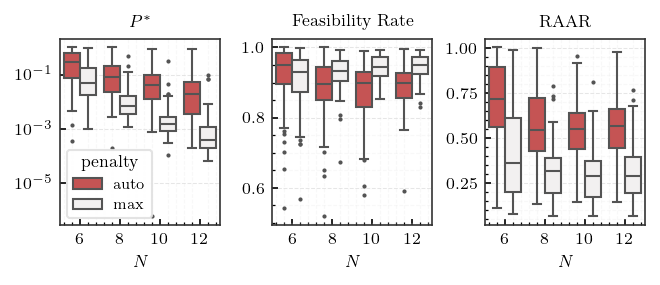

In [64]:
fig, axs = styling.subplots(1, 3, figsize=(4.5, 2))

sns.boxplot(df, x="size", y="p_opt", hue="penalty", log_scale=True, palette=sns.light_palette(styling.COLORS[1], 2)[::-1], ax=axs[0], fliersize=1)
sns.boxplot(df, x="size", y="feas_ratio", hue="penalty", log_scale=False, palette=sns.light_palette(styling.COLORS[1], 2)[::-1], ax=axs[1], fliersize=1, legend=False)
sns.boxplot(df, x="size", y="rnd_approx_ratio", hue="penalty", log_scale=False, palette=sns.light_palette(styling.COLORS[1], 2)[::-1], ax=axs[2], fliersize=1, legend=False)



axs[0].set_title("$P^*$", fontsize=8)
axs[1].set_title("Feasibility Rate", fontsize=8)
axs[2].set_title("RAAR", fontsize=8)

for a in axs:
    a.set_ylabel("")

    a.set_xlabel("$N$")

plt.tight_layout()


plt.savefig("plots/feas_raar_penalty.pdf", bbox_inches="tight")

In [49]:
!open .